## Skincare Product REcommendation System

Approach leveraged to build the Reocmmendaiton system
A correlation matrix recommendation system is a type of collaborative filtering system that uses the correlation between different items to make recommendations.

The basic approach for building a correlation matrix recommendation system is as follows:

Collect a dataset of users and their interactions with different items (e.g. ratings, purchase history, etc.).

Build a matrix of the items and the user interactions. Each row represents an item, and each column represents a user. The values in the matrix represent the interactions between the user and the item (e.g. a rating of 4 out of 5).

Calculate the pairwise correlation between all items in the matrix using a similarity metric such as Pearson correlation or cosine similarity. This will result in a correlation matrix, where each cell represents the correlation between two items.

Use the correlation matrix to make recommendations to a user. For example, if a user has shown interest in a particular item, the system can recommend similar items that have a high correlation with the item of interest.

The system can also use the correlation matrix to make recommendations to new users based on the behavior of similar users.

Model limitations - it works well only when there is a lot of data available and when the data is sparse. Also the recommendations tend to be similar items, so it may not be able to recommend new items that the user hasn't seen before.

In [1]:
import pandas as pd 
import numpy as np
import sklearn.model_selection
import sklearn.linear_model
import seaborn as sns
import sklearn.preprocessing
import sklearn.decomposition
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [2]:
##loading the data
df = pd.read_csv('sephora.csv')

In [3]:
##filtering the categories for skincare products only
skin_care = ['Moisturizers', 'Face Serums', 'Face Wash & Cleansers', 'Face Masks', 'Eye Creams & Treatments', \
             'Toners', 'Face Oils', 'Face Sunscreen', 'Sheet Masks', 'Facial Peels', 'Skincare', 'Exfoliators' \
            'Face Sets', 'Anti-Aging', 'For Face']

skincare = df[df['category'].isin(skin_care)].reset_index()
skincare.head()

,index,id,brand,category,product,size,rating,number_of_reviews,love,price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,63,1957182,Algenist,Face Serums,GENIUS Liquid Collagen,no size,4.0,656,41300,115.0,...,True,exclusive,no options,What it is: A vegan collagen treatment serum ...,Suggested Usage:-After cleansing and toning- a...,-Patented Alguronic Acid: Naturally sourced a...,0,1,0,0
1,64,2170827,Algenist,Moisturizers,GENIUS Sleeping Collagen,2 oz/ 60 mL,4.5,1000,18200,98.0,...,True,exclusive,no options,What it is: A vegan- buttery- collagen sleepi...,Suggested Usage:-After cleanser- apply a pea-s...,-Patented Alguronic Acid: Naturally sourced a...,0,1,0,0
2,66,1582477,Algenist,Moisturizers,GENIUS Ultimate Anti-Aging Cream,no size,4.5,462,16200,112.0,...,False,0,no options,What it is: A vegan- collagen-infused advance...,Suggested Usage:-After cleansing- apply to the...,-Patented Alguronic Acid: Naturally sourced a...,0,0,0,0
3,67,1328855,Algenist,Eye Creams & Treatments,Complete Eye Renewal Balm,0.5 oz/ 15 mL,4.0,873,27500,68.0,...,False,0,no options,What it is: A multitasking eye balm that prim...,Suggested Usage:-With your ring finger- which ...,-Patented Alguronic Acid: Visibly minimizes t...,0,0,0,0
4,68,1420223,Algenist,Face Sunscreen,SUBLIME DEFENSE Ultra Lightweight UV Defense F...,no size,4.5,422,21300,28.0,...,False,0,no options,What it is: An ultra-sheer- oil-free- SPF 50-...,Suggested Usage:-Shake bottle well.-Apply to t...,-Patented Alguronic Acid: Helps minimize the ...,0,0,0,0


In [4]:
skincare.shape

(1965, 22)

In [5]:
# Checking to see if the dataset has any null values

print(skincare.isnull().sum())
print(skincare.shape)

index                     0
id                        0
brand                     0
category                  0
product                   0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
URL                       0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64
(1965, 22)


In [6]:
##finding top 10 most popular products based on rating
popular_products = pd.DataFrame(skincare.groupby('product')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(10)

,rating
product,
Face Mask,3
Dr. Andrew Weil For Origins™ Mega-Mushroom Relief & Resilience Soothing Treatment Lotion,2
Clarifying Lotion 3,2
Cleanser,2
Treatment Lotion Hydrating Mask,2
Clarifying Serum,2
Triple Action Cleansing Water,2
Clarifying Lotion 2,2
Problem Solution Moisturizer,1


<AxesSubplot:xlabel='product'>

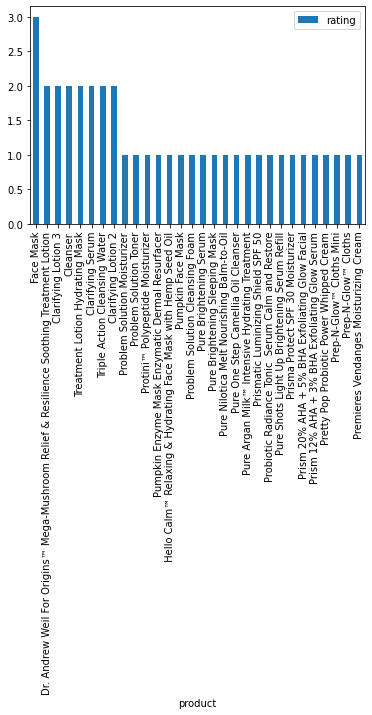

In [7]:
most_popular.head(30).plot(kind = "bar")

In [8]:
df1 = skincare.head(5000)

In [9]:
ratings_matrix = df1.pivot_table(values='rating', index='id', columns='product', fill_value=0)
ratings_matrix.head()

product,Hello Calm™ Relaxing & Hydrating Face Mask with Hemp Seed Oil,"""B"" Oil","""Buffet""","""Buffet"" + Copper Peptides 1%",#GLITTERMASK GRAVITYMUD™ Firming Treatment Mask,& Sleeping Beauty Purifying Mousse - Pink Clay Sleep Mask,+Retinol Vita C Power Serum,+Retinol Vitamin C Moisturizer,1 Minute Face Masks,10% Glycolic Solutions Moisturizer,...,anti-wrinkle miracle worker eye+ line-correcting eye cream,anti-wrinkle miracle worker night+ line-correcting overnight cream,anti-wrinkle miracle worker+ line-correcting moisturizer,knockout daily exfoliating cleanser,needles no more® NO MORE BAGGAGE™ eye de-puffing gel,pores no more® Mattifying Hydrator Pore Minimizing Gel,pores no more® Pore Purifying Cleanser,pores no more® Vacuum Cleaner® Pore Purifying Mask,sweat reset face moisturizer,Énergie de Vie The Illuminating & Anti-Fatigue Cooling Eye Gel
id,,,,,,,,,,,,,,,,,,,,,
47191,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0.0,0,0,0.0
47860,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0.0,0,0,0.0
74476,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0.0,0,0,0.0
126581,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0.0,0,0,0.0
133751,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0.0,0,0.0,0,0,0.0


In [10]:
ratings_matrix.shape

(1953, 1956)

In [11]:
X = ratings_matrix.T
X.head()

id,47191,47860,74476,126581,133751,241539,348078,348128,348144,351841,...,2348365,2349934,2351823,2352524,2353068,2353225,2353928,2354637,2354660,2354926
product,,,,,,,,,,,,,,,,,,,,,
Hello Calm™ Relaxing & Hydrating Face Mask with Hemp Seed Oil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""B"" Oil",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Buffet""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Buffet"" + Copper Peptides 1%",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
#GLITTERMASK GRAVITYMUD™ Firming Treatment Mask,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.shape

(1956, 1953)

## Matrix factorization technique - used in this model to reduce the number of features in a dataset

This code is using the TruncatedSVD (Singular Value Decomposition) function from the scikit-learn library to perform dimensionality reduction on a matrix "X".

TruncatedSVD is a type of matrix factorization technique that can be used to reduce the number of features in a dataset while preserving as much information as possible. It does this by decomposing the original matrix into three matrices: U, S, and V.

The first line of code imports the TruncatedSVD function from the scikit-learn library's decomposition module.

The second line of code creates an SVD object with n_components=10, which means that the TruncatedSVD function will reduce the number of features to 10 while preserving as much information as possible.

The third line of code uses the fit_transform() method of the SVD object to decompose the original matrix X and store the result in the variable decomposed_matrix.

The last line of code is using the shape attribute of the decomposed_matrix to return the dimensions of the matrix

In short, this code is reducing the number of features in the data set X by performing dimensionality reduction using TruncatedSVD and preserving as much information as possible by keeping 10 components from the original matrix.

In [13]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1956, 10)

In [16]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1956, 1956)

In [17]:
X.index[220]

'BioLumin-C Vitamin C Serum'

In [26]:
i = "Acid Mantle Repair Moisturizer With 250mg CBD and Ceramides"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

64

In [27]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1956,)

## Recommendation performed on database using correlation based approach

- The below recommendation system uses a correlation-based approach. The correlation_product_ID variable is a correlation matrix that shows the correlation between different products based on their ratings by users.

- The first line of code creates a list of product IDs that have a correlation coefficient greater than 0.90 with the product ID i. This means that products in this list are highly correlated with product ID i, and therefore may be good recommendations for a user who has bought product ID i.

- The second line of code removes the item i from the list of recommendations, since the user has already bought this item.

- The final line of code is slicing the list to get the first 9 items, which are the first 9 recommended items.

- The code is assuming that i is the product ID of the item that the user has already bought, and X is a DataFrame containing the user-item rating data.


In [30]:
# Recommending top 10 highly correlated products in sequence

Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:10]

[]

This approach of using correlation-based method for recommendation is simple and fast, but it has its limitations as it does not consider other factors like context, temporal information, etc. Additionally, it also assumes that the user likes the item i that they bought, which is not always the case.

##For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

##Feature extraction from product descriptions Converting the text in product description into numerical data for analysis

creates an instance of the TfidfVectorizer class, which is used to convert a collection of raw documents into a matrix of TF-IDF features. The stop_words parameter is set to 'english', which tells the vectorizer to ignore commonly used English words such as "the" and "and" that do not contain much meaningful information. The vectorizer is then fit to and transformed on the "details" column of the "product_descriptions1" dataframe, resulting in a sparse matrix representation of the TF-IDF features, which is stored in the variable X1.

## Approach 2

In [33]:
# Importing libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

In [34]:
ingredients = pd.read_csv('sephora.csv')
ingredients.shape

(9168, 21)

The command ingredients = pd.read_csv('sephora.csv') is used to read a CSV file named 'sephora.csv' and store it in a variable called 'ingredients'.
The command ingredients.shape will return a tuple representing the dimensionality of the dataframe, in the format (rows, columns). It will give the number of rows and columns in the 'ingredients' dataframe.

In [35]:
ingredients = ingredients.dropna()
ingredients.shape

(9168, 21)

The command ingredients = ingredients.dropna() is used to remove all rows from the 'ingredients' dataframe that contain at least one missing value (NaN). The dropna() function drops all the rows which has at least one NaN in any of the column.

The command ingredients.shape will return a tuple representing the dimensionality of the modified dataframe, in the format (rows, columns) after removing the NaN values. It will give the number of rows and columns in the 'ingredients' dataframe after removing the NaN values.

In [36]:
skincare = ['Moisturizers', 'Face Serums', 'Face Wash & Cleansers', 'Face Masks', 'Eye Creams & Treatments', \
             'Toners', 'Face Oils', 'Face Sunscreen', 'Sheet Masks', 'Facial Peels', 'Skincare', 'Exfoliators' \
            , 'Anti-Aging']

ingredients_skincare = ingredients[ingredients['category'].isin(skincare)].reset_index()
ingredients_skincare.head()

,index,id,brand,category,product,size,rating,number_of_reviews,love,price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,63,1957182,Algenist,Face Serums,GENIUS Liquid Collagen,no size,4.0,656,41300,115.0,...,True,exclusive,no options,What it is: A vegan collagen treatment serum ...,Suggested Usage:-After cleansing and toning- a...,-Patented Alguronic Acid: Naturally sourced a...,0,1,0,0
1,64,2170827,Algenist,Moisturizers,GENIUS Sleeping Collagen,2 oz/ 60 mL,4.5,1000,18200,98.0,...,True,exclusive,no options,What it is: A vegan- buttery- collagen sleepi...,Suggested Usage:-After cleanser- apply a pea-s...,-Patented Alguronic Acid: Naturally sourced a...,0,1,0,0
2,66,1582477,Algenist,Moisturizers,GENIUS Ultimate Anti-Aging Cream,no size,4.5,462,16200,112.0,...,False,0,no options,What it is: A vegan- collagen-infused advance...,Suggested Usage:-After cleansing- apply to the...,-Patented Alguronic Acid: Naturally sourced a...,0,0,0,0
3,67,1328855,Algenist,Eye Creams & Treatments,Complete Eye Renewal Balm,0.5 oz/ 15 mL,4.0,873,27500,68.0,...,False,0,no options,What it is: A multitasking eye balm that prim...,Suggested Usage:-With your ring finger- which ...,-Patented Alguronic Acid: Visibly minimizes t...,0,0,0,0
4,68,1420223,Algenist,Face Sunscreen,SUBLIME DEFENSE Ultra Lightweight UV Defense F...,no size,4.5,422,21300,28.0,...,False,0,no options,What it is: An ultra-sheer- oil-free- SPF 50-...,Suggested Usage:-Shake bottle well.-Apply to t...,-Patented Alguronic Acid: Helps minimize the ...,0,0,0,0


The command skincare = ['Moisturizers', 'Face Serums', 'Face Wash & Cleansers', 'Face Masks', 'Eye Creams & Treatments', \ 'Toners', 'Face Oils', 'Face Sunscreen', 'Sheet Masks', 'Facial Peels', 'Skincare', 'Exfoliators' \ , 'Anti-Aging'] is creating a list of string which contains various skincare categories.

The command ingredients_skincare = ingredients[ingredients['category'].isin(skincare)].reset_index() is creating a new dataframe 'ingredients_skincare' which contains only the rows of the 'ingredients' dataframe that have a 'category' value that is in the 'skincare' list.
The isin() function is used to filter the rows on a particular column by matching the values against a column in the dataframe. The reset_index() function is used to reset the index of the dataframe after filtering.

The command ingredients_skincare.head() will return the first 5 rows of the 'ingredients_skincare' dataframe.

In [37]:
ingredients1 = ingredients_skincare.head(500)
# ingredients1.iloc[:,1]

ingredients1["ingredients"].head(15)

0      -Patented Alguronic Acid: Naturally sourced a...
1      -Patented Alguronic Acid: Naturally sourced a...
2      -Patented Alguronic Acid: Naturally sourced a...
3      -Patented Alguronic Acid: Visibly minimizes t...
4      -Patented Alguronic Acid: Helps minimize the ...
5      -Alguronic Acid: Combats fine lines and wrink...
6     -Alguronic Acid: Improves the appearance of fi...
7      -Patented Alguronic Acid: Clinically proven t...
8      -Alguronic Acid: Increases cell regeneration ...
9      -Alguronic Acid: Supports natural cell regene...
10     -Alguronic Acid: Reduces the appearance of fi...
11     -Alguronic Acid: Improves the appearance of f...
12    Water- Dimethicone- Isododecane- Glycerin- But...
13     -Patented Alguronic Acid: visibly minimizes t...
14    -Active Vegan Collagen™: Helps reduce the appe...
Name: ingredients, dtype: object

The command ingredients1 = ingredients_skincare.head(500) is creating a new dataframe 'ingredients1' which contains only the first 500 rows of the 'ingredients_skincare' dataframe.

The command ingredients1["ingredients"].head(15) will return the first 15 rows of the "ingredients" column of the 'ingredients1' dataframe. It is subsetting the 'ingredients' column from the 'ingredients1' dataframe and then displaying the first 15 rows of it.

In [39]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(ingredients1["ingredients"])
X1

<500x3570 sparse matrix of type '<class 'numpy.float64'>'
	with 58591 stored elements in Compressed Sparse Row format>

The command vectorizer = TfidfVectorizer(stop_words='english') is creating an object of the TfidfVectorizer class and assigning it to the variable 'vectorizer', this class is used for converting a collection of raw documents to a matrix of TF-IDF features. The stop_words='english' is used to remove the english stop words from the text.

The command X1 = vectorizer.fit_transform(ingredients1["ingredients"]) is transforming the "ingredients" column of the 'ingredients1' dataframe into a sparse matrix of TF-IDF features. The fit_transform() method is used to first fit the vectorizer to the data and then transform the data.

The X1 variable now contains the sparse matrix of TF-IDF features. This matrix represents the frequency of each word in the "ingredients" column of the 'ingredients1' dataframe, weighted by how often it appears in the entire dataset and down-weighted by how frequently it appears in all the documents.

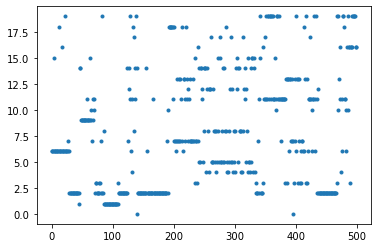

In [40]:
# Fitting K-Means to the dataset
import matplotlib.pyplot as plt
X=X1

kmeans = KMeans(n_clusters = 20, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

The command kmeans = KMeans(n_clusters = 20, init = 'k-means++') creates an object of the KMeans class and assigns it to the variable 'kmeans'. The KMeans class is used for performing K-Means clustering on the dataset. The parameter n_clusters=20 specifies that the dataset should be grouped into 20 clusters, while the init='k-means++' parameter specifies the initialization method for the centroids, 'k-means++' uses a smart initialization method to place the initial centroids in a smarter way for converging faster.

The command y_kmeans = kmeans.fit_predict(X) fits the k-means model on the dataset X and returns the cluster labels for each data point.

The command plt.plot(y_kmeans, ".") is plotting the cluster labels returned by the k-means model.

The command plt.show() is used to display the plot.

The above code is clustering the ingredients of skincare products into 20 clusters by using KMeans algorithm on the transformed ingredients column and plotting the cluster labels for each data point.

In [41]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

The above code is defining a function print_cluster(i) which takes an integer i as input. This function prints the top 10 words of the ith cluster along with the cluster number. The function is using the variables order_centroids and terms which are not defined in this snippet.

order_centroids[i, :10] is used to access the indices of the top 10 words of the ith cluster.
terms[ind] is used to access the word at the given index in the terms list.

The function is not executed in this snippet, it would work in the context of the full code where order_centroids and terms are defined and used to print the top 10 words of each cluster.

In [42]:
##Optimal clusters is 

true_k = 20

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 glucosamine
 laminaria
 saccharina
 acetyl
 kaolin
 extract
 sucrose
 salicylic
 acid
 witch
Cluster 1:
 products
 isoamyl
 methacrylate
 sterols
 fragrances
 styrene
 olivate
 synthetic
 meant
 total
Cluster 2:
 extract
 peg
 oil
 sodium
 seed
 glycol
 fruit
 triticum
 bran
 olea
Cluster 3:
 extract
 protein
 extrait
 vulgare
 peg
 glycol
 acetyl
 sodium
 dimethicone
 paul
Cluster 4:
 extract
 acid
 leaf
 fruit
 sodium
 oil
 pca
 salicylic
 skin
 flower
Cluster 5:
 extract
 ci
 glycol
 barley
 cucumber
 propylene
 seedcake
 yellow
 sunflower
 orge
Cluster 6:
 oil
 acid
 extract
 seed
 sodium
 flower
 stearate
 glycol
 leaf
 ascorbyl
Cluster 7:
 extract
 ci
 sodium
 acid
 26
 leaf
 iris
 florentina
 citrate
 glycol
Cluster 8:
 oil
 citrus
 peel
 grapefruit
 extract
 leaf
 skin
 grandis
 lavandula
 acid
Cluster 9:
 products
 methacrylate
 fragrances
 styrene
 synthetic
 total
 meant
 following
 talc
 ferment
Cluster 10:
 extract
 skin
 natural
 glycol


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The above code is finding the optimal number of clusters for the dataset and then printing the top 10 words of each cluster.

The command true_k = 20 assigns the value 20 to the variable 'true_k', which is used as the number of clusters for the KMeans model.

The command model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1) creates an object of the KMeans class and assigns it to the variable 'model'. The KMeans class is used for performing K-Means clustering on the dataset. The parameters n_clusters=true_k, init='k-means++', max_iter=100, n_init=1 specify that the dataset should be grouped into 20 clusters, the initialization method for the centroids should be 'k-means++', maximum number of iterations should be 100 and number of time the k-means algorithm will be run with different centroid seeds is 1.

The command model.fit(X1) fits the k-means model on the dataset X1.

The command order_centroids = model.cluster_centers_.argsort()[:, ::-1] is used to sort the cluster centers by proximity to centroid and returns their indices.

The command terms = vectorizer.get_feature_names() is used to get the feature names of the dataset.

The code then uses a for loop to iterate through each cluster, and for each cluster it prints the top 10 words using the function print_cluster().

The above code is finding the optimal number of clusters for the ingredients dataset using the KMeans algorithm and printing the top 10 words of each cluster.





In [43]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vectorizer.transform([product])
    prediction = model.predict(Y)
    #print(prediction)
    print_cluster(prediction[0])

The above code defines a function show_recommendations(product) that takes a product name as an input, converts it into a sparse matrix of TF-IDF features using the TfidfVectorizer object 'vectorizer' that was previously fit to the data and then predicts the cluster to which it belongs using the KMeans model 'model' that was also previously fit to the data.

The command Y = vectorizer.transform([product]) is used to transform the input product name into a sparse matrix of TF-IDF features.

The command prediction = model.predict(Y) is used to predict the cluster to which the input product belongs.

The command print_cluster(prediction[0]) is used to print the top 10 words of the cluster to which the input product belongs.

So the above function takes a product name as input, converts it into a sparse matrix of TF-IDF features and then predicts the cluster to which it belongs using the previously fit KMeans model, and prints the top 10 words of that cluster.

In [44]:
show_recommendations("aloevera")

Cluster 10:
 extract
 skin
 natural
 glycol
 sodium
 exopolysaccharides
 appearance
 algae
 acid
 collagen


The command show_recommendations("aloevera") is passing the string "aloevera" as an input to the function show_recommendations(product). The function takes the input, converts it into a sparse matrix of TF-IDF features using the TfidfVectorizer object 'vectorizer' that was previously fit to the data, and then predicts the cluster to which it belongs using the KMeans model 'model' that was also previously fit to the data. Then it prints the top 10 words of that cluster.

It is important to note that the function will only work if the KMeans model and the TfidfVectorizer object were previously fit to the dataset and the variable print_cluster(i) is also defined.
Also, The input string "aloevera" may or may not be present in the dataset and the function may or may not be able to predict the cluster accordingly.